# Crop Yield Prediction – Final Model Pipeline (Rev9)

## 1. Setup & Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import os
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import optuna
import shap

np.random.seed(42)
torch.manual_seed(42)
sns.set_style("whitegrid")
warnings.filterwarnings('ignore')
print("All libraries loaded.")

ModuleNotFoundError: No module named 'xgboost'

## 2. Model Selection Menu

In [ ]:
RUN_MODELS = {
    'LR': True,   # Baseline Linear Regression
    'RF': True,   # Random Forest
    'XGB': True,  # XGBoost
    'LSTM': True, # LSTM
    'CNN': True   # CNN
}

RUN_OPTUNA = True

## 3. Load & Preprocess Data (Corrected)

In [ ]:
# Corrected Data Preprocessing
try:
    df = pd.read_csv("cleaned_crop_data.csv")
    print(f"Loaded initial data: {df.shape}")
except FileNotFoundError:
    raise FileNotFoundError("Ensure 'cleaned_crop_data.csv' is present. Run the EDA notebook first.")

TARGET = 'hg/ha_yield'
TIME_COL = 'Year'
CAT_COLS = ['Area', 'Item']
NUMERIC_COLS = ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'fertilizer_kg/ha', 'solar_radiation_MJ/m2-day']
TARGET_DET = 'yield_detrended'

# 1. Split data chronologically
TRAIN_END = 2007
VAL_END = 2010
train_df_orig = df[df[TIME_COL] <= TRAIN_END].copy()
val_df_orig = df[(df[TIME_COL] > TRAIN_END) & (df[TIME_COL] <= VAL_END)].copy()
test_df_orig = df[df[TIME_COL] > VAL_END].copy()
print(f"1. Initial data split: Train: {train_df_orig.shape}, Val: {val_df_orig.shape}, Test: {test_df_orig.shape}")

# 2. Fit encoders ON TRAINING DATA ONLY
le_area = LabelEncoder().fit(train_df_orig['Area'])
le_item = LabelEncoder().fit(train_df_orig['Item'])
for d in [train_df_orig, val_df_orig, test_df_orig]:
    d['Area_Encoded'] = d['Area'].apply(lambda x: le_area.transform([x])[0] if x in le_area.classes_ else -1)
    d['Item_Encoded'] = d['Item'].apply(lambda x: le_item.transform([x])[0] if x in le_item.classes_ else -1)
print("2. Encoders fitted on train set and applied to all sets.")

# 3. Fit trend models ON TRAINING DATA ONLY
print("3. Fitting trend models on training data...")
trend_models = {}
for group, group_df in train_df_orig.groupby(CAT_COLS):
    trend_model = LinearRegression()
    trend_model.fit(group_df[[TIME_COL]], group_df[TARGET])
    trend_models[group] = trend_model

global_trend_model = LinearRegression().fit(train_df_orig[[TIME_COL]], train_df_orig[TARGET])
print(f"   Fitted {len(trend_models)} group-specific trend models and 1 global model.")

# 4. Apply detrending to all datasets
for df_set in [train_df_orig, val_df_orig, test_df_orig]:
    df_set['yield_trend'] = 0.0
    for group, group_df in df_set.groupby(CAT_COLS):
        model = trend_models.get(group, global_trend_model)
        trend_prediction = model.predict(group_df[[TIME_COL]])
        df_set.loc[group_df.index, 'yield_trend'] = trend_prediction
    df_set['yield_detrended'] = df_set[TARGET] - df_set['yield_trend']
print("   Detrending applied to all datasets.")

# 5. Create lags and finalize split for ML models
full_df_ml = pd.concat([train_df_orig, val_df_orig, test_df_orig]).sort_values(CAT_COLS + [TIME_COL])
lag_cols = ['yield_detrended'] + NUMERIC_COLS
for col in lag_cols:
    for lag in [1, 2]:
        full_df_ml[f'{col}_lag{lag}'] = full_df_ml.groupby(CAT_COLS)[col].shift(lag)

df_ml = full_df_ml.dropna().copy()
train_df = df_ml[df_ml[TIME_COL] <= TRAIN_END].copy()
val_df = df_ml[(df_ml[TIME_COL] > TRAIN_END) & (df_ml[TIME_COL] <= VAL_END)].copy()
test_df = df_ml[df_ml[TIME_COL] > VAL_END].copy()
print(f"4. Lags created for ML models: Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}")

# 6. Fit scalers for ML models ON TRAINING DATA ONLY
lagged_cols = [c for c in df_ml.columns if '_lag' in c]
ml_features = NUMERIC_COLS + lagged_cols + ['Area_Encoded', 'Item_Encoded']
scale_cols = NUMERIC_COLS + lagged_cols

x_scaler = StandardScaler()
train_df[scale_cols] = x_scaler.fit_transform(train_df[scale_cols])
val_df[scale_cols] = x_scaler.transform(val_df[scale_cols])
test_df[scale_cols] = x_scaler.transform(test_df[scale_cols])

y_scaler = StandardScaler()
train_df[TARGET_DET] = y_scaler.fit_transform(train_df[[TARGET_DET]])
val_df[TARGET_DET] = y_scaler.transform(val_df[[TARGET_DET]])
test_df[TARGET_DET] = y_scaler.transform(test_df[[TARGET_DET]])
print("5. X and y scalers for ML models fitted and applied.")

# 7. Save transformers
joblib.dump(x_scaler, 'scaler.joblib')
joblib.dump(y_scaler, 'y_scaler.joblib')
joblib.dump(le_area, 'le_area.joblib')
joblib.dump(le_item, 'le_item.joblib')
joblib.dump(trend_models, 'trend_models.joblib')
joblib.dump(global_trend_model, 'global_trend_model.joblib')
print("6. All transformers saved to disk.")

N_AREAS = len(le_area.classes_)
N_ITEMS = len(le_item.classes_)

Loaded initial data: (25932, 9)
1. Initial data split: Train: (19032, 9), Val: (3424, 9), Test: (3476, 9)
2. Encoders fitted on train set and applied to all sets.
3. Fitting trend models on training data...
   Fitted 588 group-specific trend models and 1 global model.
   Detrending applied to all datasets.
4. Lags created for ML models: Train: (17857, 25), Val: (3421, 25), Test: (3459, 25)
5. X and y scalers for ML models fitted and applied.
6. All transformers saved to disk.


## 4. Prepare Inputs (Corrected)

In [ ]:
# ML Inputs
X_train_ml = train_df[ml_features]
y_train_ml = train_df[TARGET_DET]
X_val_ml = val_df[ml_features]
y_val_ml = val_df[TARGET_DET]
X_test_ml = test_df[ml_features]
y_test_ml = test_df[TARGET_DET]
print("ML inputs prepared.")

# DL Inputs
LOOKBACK = 5
DL_FEATS = NUMERIC_COLS + ['Area_Encoded', 'Item_Encoded']

# Correctly scale DL features
scaler_dl_x = StandardScaler()
train_df_orig[NUMERIC_COLS] = scaler_dl_x.fit_transform(train_df_orig[NUMERIC_COLS])
val_df_orig[NUMERIC_COLS] = scaler_dl_x.transform(val_df_orig[NUMERIC_COLS])
test_df_orig[NUMERIC_COLS] = scaler_dl_x.transform(test_df_orig[NUMERIC_COLS])

# Use the already fitted y_scaler for the target
train_df_orig[TARGET_DET] = y_scaler.transform(train_df_orig[[TARGET_DET]])
val_df_orig[TARGET_DET] = y_scaler.transform(val_df_orig[[TARGET_DET]])
test_df_orig[TARGET_DET] = y_scaler.transform(test_df_orig[[TARGET_DET]])
print("DL features and target scaled.")

def create_sequences(data, lookback, feats, target):
    X, y = [], []
    # Keep track of original index
    y_indices = []
    for _, group in data.groupby(CAT_COLS):
        if len(group) < lookback:
            continue
        gf = group[feats].values
        gt = group[target].values
        indices = group.index
        for i in range(len(group) - lookback + 1):
            X.append(gf[i:i+lookback])
            y.append(gt[i+lookback-1])
            y_indices.append(indices[i+lookback-1])
    return np.array(X), np.array(y), y_indices

X_train_seq, y_train_seq, _ = create_sequences(train_df_orig, LOOKBACK, DL_FEATS, TARGET_DET)
X_val_seq, y_val_seq, _ = create_sequences(val_df_orig, LOOKBACK, DL_FEATS, TARGET_DET)
X_test_seq, y_test_seq, y_test_indices = create_sequences(test_df_orig, LOOKBACK, DL_FEATS, TARGET_DET)
print("DL sequences created.")

# Create a reference dataframe for test set evaluation
test_df_dl_seq_ref = test_df_orig.loc[y_test_indices]

def split_dl(X):
    # The number of numeric features is len(NUMERIC_COLS)
    numeric_feature_count = len(NUMERIC_COLS)
    return [
        torch.tensor(X[..., :numeric_feature_count], dtype=torch.float32),
        torch.tensor(X[..., numeric_feature_count], dtype=torch.long),
        torch.tensor(X[..., numeric_feature_count+1], dtype=torch.long)
    ]

X_train_dl = split_dl(X_train_seq)
X_val_dl = split_dl(X_val_seq)
X_test_dl = split_dl(X_test_seq)

y_train_t = torch.tensor(y_train_seq, dtype=torch.float32).unsqueeze(1)
y_val_t = torch.tensor(y_val_seq, dtype=torch.float32).unsqueeze(1)
y_test_t = torch.tensor(y_test_seq, dtype=torch.float32).unsqueeze(1)
print("DL tensors created.")

ML inputs prepared.
DL features and target scaled.
DL sequences created.
DL tensors created.


## 5. Metrics

In [ ]:
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred) / (y_true + 1e-8)) ** 2)) * 100

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

## 6. Optuna Objectives (Corrected)

In [ ]:
def objective_lr(trial):
    # No hyperparameters to tune for Linear Regression
    model = LinearRegression()
    model.fit(X_train_ml, y_train_ml)
    preds = model.predict(X_val_ml)
    return np.sqrt(mean_squared_error(y_val_ml, preds)) # Return RMSE

def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0)
    }
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train_ml, y_train_ml)
    preds = model.predict(X_val_ml)
    return np.sqrt(mean_squared_error(y_val_ml, preds)) # Return RMSE

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000), 
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.05, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'early_stopping_rounds': 50, # Increase patience for lower LR
        'eval_metric': 'rmse'
    }

    model = xgb.XGBRegressor(
        random_state=42,
        **params
    )

    model.fit(
        X_train_ml, y_train_ml,
        eval_set=[(X_val_ml, y_val_ml)],
        verbose=False
    )

    preds = model.predict(X_val_ml)
    return np.sqrt(mean_squared_error(y_val_ml, preds)) # Return RMSE

class LSTMModel(nn.Module):
    def __init__(self, n_areas, n_items, lstm_units, dense_units, dropout):
        super().__init__()
        self.embed_area = nn.Embedding(n_areas, 10)
        self.embed_item = nn.Embedding(n_items, 5)
        self.lstm = nn.LSTM(len(NUMERIC_COLS) + 10 + 5, lstm_units, batch_first=True)
        self.drop = nn.Dropout(dropout)
        self.fc1 = nn.Linear(lstm_units, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)
    def forward(self, num, area, item):
        e_area = self.embed_area(area)
        e_item = self.embed_item(item)
        x = torch.cat([num, e_area, e_item], dim=-1)
        out, _ = self.lstm(x)
        out = self.drop(out[:, -1])
        out = torch.relu(self.fc1(out))
        return self.fc2(out)

def train_dl(model, opt, loss_fn, train_loader, val_loader, target_scaler, epochs=100, patience=10, is_final=False):
    scheduler = ReduceLROnPlateau(opt, 'min', patience=5, factor=0.5)
    best_val_rmse = float('inf') # Optimize for RMSE
    wait = 0
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x1, x2, x3, y in train_loader:
            opt.zero_grad()
            pred = model(x1, x2, x3)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))
        
        model.eval()
        with torch.no_grad():
            val_inputs = [x.to(next(model.parameters()).device) for x in val_loader.dataset.tensors[:3]]
            val_y = val_loader.dataset.tensors[3]
            val_pred = model(*val_inputs)
            val_mse = loss_fn(val_pred, val_y).item()
            val_rmse = np.sqrt(val_mse) # Calculate RMSE
            val_losses.append(val_mse)

        scheduler.step(val_rmse) # Step based on validation RMSE

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            wait = 0
            if is_final:
                 torch.save(model.state_dict(), f'model_{model.__class__.__name__}.pth')
        else:
            wait += 1
            if wait >= patience:
                break
    return train_losses, val_losses, best_val_rmse

def objective_lstm(trial):
    params = {
        'lstm_units': trial.suggest_categorical('lstm_units', [64, 128]),
        'dense_units': trial.suggest_categorical('dense_units', [32, 64]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.4),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    }
    lr = params.pop('lr')
    weight_decay = params.pop('weight_decay')
    model = LSTMModel(N_AREAS, N_ITEMS, **params)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_ds = TensorDataset(*X_train_dl, y_train_t)
    val_ds = TensorDataset(*X_val_dl, y_val_t)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64)
    _, _, best_val_rmse = train_dl(model, opt, nn.MSELoss(), train_loader, val_loader, y_scaler)
    return best_val_rmse

class CNNModel(nn.Module):
    def __init__(self, n_areas, n_items, filters, kernel, dense_units): 
        super().__init__()
        self.embed_area = nn.Embedding(n_areas, 10)
        self.embed_item = nn.Embedding(n_items, 5)
        self.conv = nn.Conv1d(len(NUMERIC_COLS) + 10 + 5, filters, kernel)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(filters, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)
    def forward(self, num, area, item):
        e_area = self.embed_area(area)
        e_item = self.embed_item(item)
        x = torch.cat([num, e_area, e_item], dim=-1).transpose(1, 2)
        x = torch.relu(self.conv(x))
        x = self.pool(x).squeeze(-1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

def objective_cnn(trial):
    params = {
        'filters': trial.suggest_categorical('filters', [64, 128]),
        'kernel': trial.suggest_categorical('kernel', [2, 3]),
        'dense_units': trial.suggest_categorical('dense_units', [32, 64]),
        'lr': trial.suggest_float('lr', 1e-4, 1e-2, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    }
    lr = params.pop('lr')
    weight_decay = params.pop('weight_decay')
    model = CNNModel(N_AREAS, N_ITEMS, **params)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_ds = TensorDataset(*X_train_dl, y_train_t)
    val_ds = TensorDataset(*X_val_dl, y_val_t)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64)
    _, _, best_val_rmse = train_dl(model, opt, nn.MSELoss(), train_loader, val_loader, y_scaler)
    return best_val_rmse

## 7. Run Optuna

In [ ]:
if os.path.exists('best_params_optuna.joblib'):
    best_params = joblib.load('best_params_optuna.joblib')
else:
    best_params = {}

if RUN_OPTUNA:
    studies = {}
    objectives = {
        'LR': objective_lr,
        'RF': objective_rf,
        'XGB': objective_xgb,
        'LSTM': objective_lstm,
        'CNN': objective_cnn
    }
    for name, run in RUN_MODELS.items():
        if run:
            print(f'--- Tuning {name} ---')
            study = optuna.create_study(direction='minimize')
            n_trials = 50 if name in ['RF', 'XGB'] else 30
            if name == 'LR':
                n_trials = 1
            study.optimize(objectives[name], n_trials=n_trials, show_progress_bar=True)
            best_params[name] = study.best_params
            studies[name] = study
            joblib.dump(best_params, 'best_params_optuna.joblib') # Save after each study
            print(f'Best params for {name}: {study.best_params}')
else:
    print('Skipping Optuna tuning.')

[I 2025-11-18 14:34:33,598] A new study created in memory with name: no-name-acb25cbc-22c4-47fb-b44f-d371296a01e2


--- Tuning LR ---


Best trial: 0. Best value: 1.18775: 100%|██████████| 1/1 [00:00<00:00, 52.38it/s]
[I 2025-11-18 14:34:33,624] A new study created in memory with name: no-name-4a08fb5c-17ae-4a96-a41b-566e24a0c3f2


[I 2025-11-18 14:34:33,613] Trial 0 finished with value: 1.1877468914521914 and parameters: {}. Best is trial 0 with value: 1.1877468914521914.
Best params for LR: {}
--- Tuning RF ---


Best trial: 0. Best value: 1.32996:   2%|▏         | 1/50 [00:06<04:57,  6.07s/it]

[I 2025-11-18 14:34:39,695] Trial 0 finished with value: 1.3299590176727218 and parameters: {'n_estimators': 340, 'max_depth': 15, 'min_samples_leaf': 8, 'max_features': 0.6504351397038632}. Best is trial 0 with value: 1.3299590176727218.


Best trial: 1. Best value: 1.32057:   4%|▍         | 2/50 [00:16<06:56,  8.68s/it]

[I 2025-11-18 14:34:50,200] Trial 1 finished with value: 1.3205667715051468 and parameters: {'n_estimators': 315, 'max_depth': 24, 'min_samples_leaf': 3, 'max_features': 0.8958797804072299}. Best is trial 1 with value: 1.3205667715051468.


Best trial: 1. Best value: 1.32057:   6%|▌         | 3/50 [00:20<05:10,  6.61s/it]

[I 2025-11-18 14:34:54,351] Trial 2 finished with value: 1.3371160068695807 and parameters: {'n_estimators': 230, 'max_depth': 21, 'min_samples_leaf': 6, 'max_features': 0.5372458673724423}. Best is trial 1 with value: 1.3205667715051468.


Best trial: 1. Best value: 1.32057:   8%|▊         | 4/50 [00:22<03:44,  4.88s/it]

[I 2025-11-18 14:34:56,583] Trial 3 finished with value: 1.3412644707828558 and parameters: {'n_estimators': 149, 'max_depth': 14, 'min_samples_leaf': 3, 'max_features': 0.6247015765093733}. Best is trial 1 with value: 1.3205667715051468.


Best trial: 4. Best value: 1.30414:  10%|█         | 5/50 [00:26<03:17,  4.39s/it]

[I 2025-11-18 14:35:00,095] Trial 4 finished with value: 1.3041415821142668 and parameters: {'n_estimators': 174, 'max_depth': 14, 'min_samples_leaf': 6, 'max_features': 0.8488438608564135}. Best is trial 4 with value: 1.3041415821142668.


Best trial: 5. Best value: 1.30041:  12%|█▏        | 6/50 [00:27<02:29,  3.40s/it]

[I 2025-11-18 14:35:01,581] Trial 5 finished with value: 1.3004125237768758 and parameters: {'n_estimators': 58, 'max_depth': 15, 'min_samples_leaf': 6, 'max_features': 0.9088213848438291}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  14%|█▍        | 7/50 [00:30<02:18,  3.21s/it]

[I 2025-11-18 14:35:04,396] Trial 6 finished with value: 1.328640241941644 and parameters: {'n_estimators': 320, 'max_depth': 5, 'min_samples_leaf': 9, 'max_features': 0.8909881413882523}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  16%|█▌        | 8/50 [00:32<02:01,  2.90s/it]

[I 2025-11-18 14:35:06,617] Trial 7 finished with value: 1.3130174968263388 and parameters: {'n_estimators': 71, 'max_depth': 23, 'min_samples_leaf': 5, 'max_features': 0.7898079624707193}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  18%|█▊        | 9/50 [00:36<02:08,  3.13s/it]

[I 2025-11-18 14:35:10,257] Trial 8 finished with value: 1.3098724608139394 and parameters: {'n_estimators': 187, 'max_depth': 11, 'min_samples_leaf': 8, 'max_features': 0.9519241987154805}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  20%|██        | 10/50 [00:40<02:14,  3.36s/it]

[I 2025-11-18 14:35:14,131] Trial 9 finished with value: 1.3136738508018913 and parameters: {'n_estimators': 126, 'max_depth': 28, 'min_samples_leaf': 8, 'max_features': 0.9403209616951114}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  22%|██▏       | 11/50 [00:41<01:40,  2.59s/it]

[I 2025-11-18 14:35:14,976] Trial 10 finished with value: 1.3654950937993462 and parameters: {'n_estimators': 50, 'max_depth': 8, 'min_samples_leaf': 1, 'max_features': 0.9996318011386496}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  24%|██▍       | 12/50 [00:46<02:10,  3.44s/it]

[I 2025-11-18 14:35:20,376] Trial 11 finished with value: 1.3106085211607224 and parameters: {'n_estimators': 237, 'max_depth': 18, 'min_samples_leaf': 6, 'max_features': 0.8004675649510197}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  26%|██▌       | 13/50 [00:49<01:55,  3.11s/it]

[I 2025-11-18 14:35:22,715] Trial 12 finished with value: 1.3095474966723808 and parameters: {'n_estimators': 111, 'max_depth': 12, 'min_samples_leaf': 5, 'max_features': 0.8434332247486986}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  28%|██▊       | 14/50 [00:52<01:54,  3.18s/it]

[I 2025-11-18 14:35:26,059] Trial 13 finished with value: 1.330639764170545 and parameters: {'n_estimators': 182, 'max_depth': 18, 'min_samples_leaf': 10, 'max_features': 0.7361350477745707}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  30%|███       | 15/50 [00:56<02:03,  3.53s/it]

[I 2025-11-18 14:35:30,409] Trial 14 finished with value: 1.3175135902274595 and parameters: {'n_estimators': 393, 'max_depth': 9, 'min_samples_leaf': 4, 'max_features': 0.7176227642986217}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  32%|███▏      | 16/50 [00:58<01:46,  3.13s/it]

[I 2025-11-18 14:35:32,599] Trial 15 finished with value: 1.3109730553180918 and parameters: {'n_estimators': 90, 'max_depth': 16, 'min_samples_leaf': 7, 'max_features': 0.8555089352777568}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  34%|███▍      | 17/50 [01:05<02:21,  4.28s/it]

[I 2025-11-18 14:35:39,560] Trial 16 finished with value: 1.3093087724462067 and parameters: {'n_estimators': 272, 'max_depth': 20, 'min_samples_leaf': 7, 'max_features': 0.7982812171175536}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  36%|███▌      | 18/50 [01:09<02:10,  4.08s/it]

[I 2025-11-18 14:35:43,163] Trial 17 finished with value: 1.304817182064577 and parameters: {'n_estimators': 164, 'max_depth': 12, 'min_samples_leaf': 4, 'max_features': 0.9961292449735848}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  38%|███▊      | 19/50 [01:12<01:53,  3.67s/it]

[I 2025-11-18 14:35:45,900] Trial 18 finished with value: 1.3367110215521913 and parameters: {'n_estimators': 206, 'max_depth': 8, 'min_samples_leaf': 2, 'max_features': 0.9063389853803229}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  40%|████      | 20/50 [01:16<01:52,  3.74s/it]

[I 2025-11-18 14:35:49,798] Trial 19 finished with value: 1.3132711073736774 and parameters: {'n_estimators': 130, 'max_depth': 29, 'min_samples_leaf': 7, 'max_features': 0.8432998967519493}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  42%|████▏     | 21/50 [01:17<01:31,  3.14s/it]

[I 2025-11-18 14:35:51,542] Trial 20 finished with value: 1.3518983758918457 and parameters: {'n_estimators': 270, 'max_depth': 5, 'min_samples_leaf': 4, 'max_features': 0.6762267050064549}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 5. Best value: 1.30041:  44%|████▍     | 22/50 [01:21<01:35,  3.41s/it]

[I 2025-11-18 14:35:55,584] Trial 21 finished with value: 1.3087785655506883 and parameters: {'n_estimators': 161, 'max_depth': 13, 'min_samples_leaf': 4, 'max_features': 0.9959169713225487}. Best is trial 5 with value: 1.3004125237768758.


Best trial: 22. Best value: 1.29512:  46%|████▌     | 23/50 [01:24<01:28,  3.28s/it]

[I 2025-11-18 14:35:58,569] Trial 22 finished with value: 1.2951212086867037 and parameters: {'n_estimators': 161, 'max_depth': 11, 'min_samples_leaf': 5, 'max_features': 0.949709393663719}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  48%|████▊     | 24/50 [01:26<01:12,  2.78s/it]

[I 2025-11-18 14:36:00,183] Trial 23 finished with value: 1.3068713186264231 and parameters: {'n_estimators': 97, 'max_depth': 10, 'min_samples_leaf': 6, 'max_features': 0.9454313950700525}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  50%|█████     | 25/50 [01:27<00:58,  2.32s/it]

[I 2025-11-18 14:36:01,427] Trial 24 finished with value: 1.3020481274517124 and parameters: {'n_estimators': 50, 'max_depth': 16, 'min_samples_leaf': 5, 'max_features': 0.8860955456200845}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  52%|█████▏    | 26/50 [01:29<00:48,  2.04s/it]

[I 2025-11-18 14:36:02,814] Trial 25 finished with value: 1.3034760080335535 and parameters: {'n_estimators': 52, 'max_depth': 17, 'min_samples_leaf': 5, 'max_features': 0.9220330699226864}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  54%|█████▍    | 27/50 [01:32<00:53,  2.32s/it]

[I 2025-11-18 14:36:05,771] Trial 26 finished with value: 1.314147306829754 and parameters: {'n_estimators': 86, 'max_depth': 20, 'min_samples_leaf': 3, 'max_features': 0.9595010615688824}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  56%|█████▌    | 28/50 [01:33<00:44,  2.04s/it]

[I 2025-11-18 14:36:07,174] Trial 27 finished with value: 1.3163918998998765 and parameters: {'n_estimators': 68, 'max_depth': 16, 'min_samples_leaf': 5, 'max_features': 0.7836557696769251}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  58%|█████▊    | 29/50 [01:34<00:38,  1.86s/it]

[I 2025-11-18 14:36:08,599] Trial 28 finished with value: 1.3121363847471075 and parameters: {'n_estimators': 130, 'max_depth': 7, 'min_samples_leaf': 5, 'max_features': 0.8758045664743321}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  60%|██████    | 30/50 [01:36<00:37,  1.87s/it]

[I 2025-11-18 14:36:10,488] Trial 29 finished with value: 1.3005934088662672 and parameters: {'n_estimators': 77, 'max_depth': 15, 'min_samples_leaf': 7, 'max_features': 0.9637396921444108}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  62%|██████▏   | 31/50 [01:39<00:39,  2.09s/it]

[I 2025-11-18 14:36:13,087] Trial 30 finished with value: 1.3160874165888743 and parameters: {'n_estimators': 112, 'max_depth': 14, 'min_samples_leaf': 9, 'max_features': 0.968653705932423}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  64%|██████▍   | 32/50 [01:41<00:35,  1.99s/it]

[I 2025-11-18 14:36:14,860] Trial 31 finished with value: 1.306070686893522 and parameters: {'n_estimators': 70, 'max_depth': 16, 'min_samples_leaf': 7, 'max_features': 0.9235031458845083}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  66%|██████▌   | 33/50 [01:42<00:28,  1.67s/it]

[I 2025-11-18 14:36:15,774] Trial 32 finished with value: 1.303792218857978 and parameters: {'n_estimators': 50, 'max_depth': 11, 'min_samples_leaf': 6, 'max_features': 0.8778289915136402}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  68%|██████▊   | 34/50 [01:44<00:31,  1.99s/it]

[I 2025-11-18 14:36:18,500] Trial 33 finished with value: 1.3120832389649149 and parameters: {'n_estimators': 98, 'max_depth': 19, 'min_samples_leaf': 7, 'max_features': 0.9083635685890317}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  70%|███████   | 35/50 [01:49<00:42,  2.86s/it]

[I 2025-11-18 14:36:23,395] Trial 34 finished with value: 1.3286508999421474 and parameters: {'n_estimators': 148, 'max_depth': 23, 'min_samples_leaf': 3, 'max_features': 0.9687812697869423}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  72%|███████▏  | 36/50 [01:50<00:32,  2.35s/it]

[I 2025-11-18 14:36:24,571] Trial 35 finished with value: 1.3363340474486922 and parameters: {'n_estimators': 76, 'max_depth': 15, 'min_samples_leaf': 6, 'max_features': 0.5944218172313438}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  74%|███████▍  | 37/50 [01:52<00:25,  1.99s/it]

[I 2025-11-18 14:36:25,721] Trial 36 finished with value: 1.3439128655892887 and parameters: {'n_estimators': 111, 'max_depth': 13, 'min_samples_leaf': 8, 'max_features': 0.5153358990613301}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  76%|███████▌  | 38/50 [01:56<00:32,  2.68s/it]

[I 2025-11-18 14:36:29,994] Trial 37 finished with value: 1.3158282711249134 and parameters: {'n_estimators': 216, 'max_depth': 15, 'min_samples_leaf': 9, 'max_features': 0.8123243663534531}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  78%|███████▊  | 39/50 [02:00<00:32,  2.99s/it]

[I 2025-11-18 14:36:33,714] Trial 38 finished with value: 1.30481649762872 and parameters: {'n_estimators': 151, 'max_depth': 17, 'min_samples_leaf': 5, 'max_features': 0.8808239532294891}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  80%|████████  | 40/50 [02:07<00:43,  4.33s/it]

[I 2025-11-18 14:36:41,176] Trial 39 finished with value: 1.3030575681299423 and parameters: {'n_estimators': 245, 'max_depth': 25, 'min_samples_leaf': 6, 'max_features': 0.9294864119900059}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  82%|████████▏ | 41/50 [02:09<00:32,  3.60s/it]

[I 2025-11-18 14:36:43,073] Trial 40 finished with value: 1.305751608131547 and parameters: {'n_estimators': 63, 'max_depth': 21, 'min_samples_leaf': 8, 'max_features': 0.9727485377913143}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  84%|████████▍ | 42/50 [02:17<00:38,  4.87s/it]

[I 2025-11-18 14:36:50,912] Trial 41 finished with value: 1.304726899893386 and parameters: {'n_estimators': 252, 'max_depth': 24, 'min_samples_leaf': 6, 'max_features': 0.9299285875453662}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  86%|████████▌ | 43/50 [02:25<00:41,  5.97s/it]

[I 2025-11-18 14:36:59,440] Trial 42 finished with value: 1.3077287589377913 and parameters: {'n_estimators': 298, 'max_depth': 27, 'min_samples_leaf': 7, 'max_features': 0.9372626094673685}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  88%|████████▊ | 44/50 [02:31<00:35,  5.85s/it]

[I 2025-11-18 14:37:05,006] Trial 43 finished with value: 1.305489907530087 and parameters: {'n_estimators': 192, 'max_depth': 26, 'min_samples_leaf': 6, 'max_features': 0.9044909541832129}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  90%|█████████ | 45/50 [02:38<00:30,  6.17s/it]

[I 2025-11-18 14:37:11,923] Trial 44 finished with value: 1.3077752718181288 and parameters: {'n_estimators': 358, 'max_depth': 13, 'min_samples_leaf': 5, 'max_features': 0.8225818832462511}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  92%|█████████▏| 46/50 [02:43<00:23,  5.95s/it]

[I 2025-11-18 14:37:17,362] Trial 45 finished with value: 1.307790713093875 and parameters: {'n_estimators': 258, 'max_depth': 14, 'min_samples_leaf': 4, 'max_features': 0.8660941755551577}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  94%|█████████▍| 47/50 [02:49<00:17,  5.76s/it]

[I 2025-11-18 14:37:22,671] Trial 46 finished with value: 1.3003535845667678 and parameters: {'n_estimators': 290, 'max_depth': 11, 'min_samples_leaf': 6, 'max_features': 0.89595710148699}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  96%|█████████▌| 48/50 [02:53<00:10,  5.31s/it]

[I 2025-11-18 14:37:26,943] Trial 47 finished with value: 1.3206090474021068 and parameters: {'n_estimators': 291, 'max_depth': 11, 'min_samples_leaf': 8, 'max_features': 0.7612520644522336}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512:  98%|█████████▊| 49/50 [02:58<00:05,  5.28s/it]

[I 2025-11-18 14:37:32,135] Trial 48 finished with value: 1.3060371523894876 and parameters: {'n_estimators': 359, 'max_depth': 10, 'min_samples_leaf': 5, 'max_features': 0.8352152335175933}. Best is trial 22 with value: 1.2951212086867037.


Best trial: 22. Best value: 1.29512: 100%|██████████| 50/50 [03:00<00:00,  3.61s/it]
[I 2025-11-18 14:37:34,058] A new study created in memory with name: no-name-7149d29a-d3f8-406a-90d0-90b5f86e0061


[I 2025-11-18 14:37:34,052] Trial 49 finished with value: 1.3106363760312993 and parameters: {'n_estimators': 83, 'max_depth': 15, 'min_samples_leaf': 7, 'max_features': 0.8895635349220234}. Best is trial 22 with value: 1.2951212086867037.
Best params for RF: {'n_estimators': 161, 'max_depth': 11, 'min_samples_leaf': 5, 'max_features': 0.949709393663719}
--- Tuning XGB ---


Best trial: 0. Best value: 1.41208:   2%|▏         | 1/50 [00:02<02:07,  2.60s/it]

[I 2025-11-18 14:37:36,654] Trial 0 finished with value: 1.4120829214943575 and parameters: {'n_estimators': 1431, 'max_depth': 6, 'learning_rate': 0.0025966946496019084, 'subsample': 0.9735132526857847, 'colsample_bytree': 0.8795318125260778, 'gamma': 1.5404670240565388}. Best is trial 0 with value: 1.4120829214943575.


Best trial: 0. Best value: 1.41208:   4%|▍         | 2/50 [00:03<01:06,  1.39s/it]

[I 2025-11-18 14:37:37,193] Trial 1 finished with value: 1.4181488174969448 and parameters: {'n_estimators': 589, 'max_depth': 4, 'learning_rate': 0.0059699687430672796, 'subsample': 0.8721592203724717, 'colsample_bytree': 0.6962814269001503, 'gamma': 1.2648327238854506}. Best is trial 0 with value: 1.4120829214943575.


Best trial: 0. Best value: 1.41208:   6%|▌         | 3/50 [00:04<01:02,  1.34s/it]

[I 2025-11-18 14:37:38,474] Trial 2 finished with value: 1.5117432341835964 and parameters: {'n_estimators': 1063, 'max_depth': 5, 'learning_rate': 0.0015375809613112372, 'subsample': 0.9422702904332496, 'colsample_bytree': 0.6239019695765092, 'gamma': 0.7656080853193586}. Best is trial 0 with value: 1.4120829214943575.


Best trial: 0. Best value: 1.41208:   8%|▊         | 4/50 [00:06<01:10,  1.52s/it]

[I 2025-11-18 14:37:40,283] Trial 3 finished with value: 1.4357545361864608 and parameters: {'n_estimators': 1802, 'max_depth': 12, 'learning_rate': 0.007827556371739234, 'subsample': 0.7885950386006202, 'colsample_bytree': 0.704485241902442, 'gamma': 3.0905712953090947}. Best is trial 0 with value: 1.4120829214943575.


Best trial: 4. Best value: 1.39171:  10%|█         | 5/50 [00:06<00:47,  1.06s/it]

[I 2025-11-18 14:37:40,520] Trial 4 finished with value: 1.391714885405944 and parameters: {'n_estimators': 777, 'max_depth': 6, 'learning_rate': 0.044042695271538916, 'subsample': 0.9888263119998113, 'colsample_bytree': 0.9521605874192288, 'gamma': 4.628521223523347}. Best is trial 4 with value: 1.391714885405944.


Best trial: 4. Best value: 1.39171:  12%|█▏        | 6/50 [00:07<00:44,  1.00s/it]

[I 2025-11-18 14:37:41,416] Trial 5 finished with value: 1.4327678894212617 and parameters: {'n_estimators': 680, 'max_depth': 6, 'learning_rate': 0.004451141939205593, 'subsample': 0.6981356851198878, 'colsample_bytree': 0.6094351606082342, 'gamma': 3.223941012361981}. Best is trial 4 with value: 1.391714885405944.


Best trial: 4. Best value: 1.39171:  14%|█▍        | 7/50 [00:09<00:58,  1.36s/it]

[I 2025-11-18 14:37:43,498] Trial 6 finished with value: 1.4558039809525616 and parameters: {'n_estimators': 956, 'max_depth': 7, 'learning_rate': 0.0018690894489624, 'subsample': 0.8956546315069005, 'colsample_bytree': 0.9575070889448563, 'gamma': 1.681200838913156}. Best is trial 4 with value: 1.391714885405944.


Best trial: 7. Best value: 1.38764:  16%|█▌        | 8/50 [00:10<00:51,  1.23s/it]

[I 2025-11-18 14:37:44,455] Trial 7 finished with value: 1.3876394882695167 and parameters: {'n_estimators': 1740, 'max_depth': 4, 'learning_rate': 0.004150327683404526, 'subsample': 0.6342036514596497, 'colsample_bytree': 0.9127220061638309, 'gamma': 2.9415454842079476}. Best is trial 7 with value: 1.3876394882695167.


Best trial: 7. Best value: 1.38764:  18%|█▊        | 9/50 [00:12<00:55,  1.35s/it]

[I 2025-11-18 14:37:46,087] Trial 8 finished with value: 1.4149218176375067 and parameters: {'n_estimators': 1568, 'max_depth': 9, 'learning_rate': 0.007627574138456961, 'subsample': 0.6111086964661742, 'colsample_bytree': 0.851807211802007, 'gamma': 1.1045932875424396}. Best is trial 7 with value: 1.3876394882695167.


Best trial: 7. Best value: 1.38764:  20%|██        | 10/50 [00:12<00:40,  1.01s/it]

[I 2025-11-18 14:37:46,331] Trial 9 finished with value: 1.3926232920270492 and parameters: {'n_estimators': 1110, 'max_depth': 6, 'learning_rate': 0.0413744251442915, 'subsample': 0.7775048001896501, 'colsample_bytree': 0.9653772415226897, 'gamma': 0.3604749645900007}. Best is trial 7 with value: 1.3876394882695167.


Best trial: 10. Best value: 1.36729:  22%|██▏       | 11/50 [00:12<00:30,  1.26it/s]

[I 2025-11-18 14:37:46,628] Trial 10 finished with value: 1.3672888198643598 and parameters: {'n_estimators': 1984, 'max_depth': 3, 'learning_rate': 0.018147416465636248, 'subsample': 0.6349953631780212, 'colsample_bytree': 0.7881067238369017, 'gamma': 4.71134819862173}. Best is trial 10 with value: 1.3672888198643598.


Best trial: 11. Best value: 1.3583:  24%|██▍       | 12/50 [00:12<00:24,  1.58it/s] 

[I 2025-11-18 14:37:46,894] Trial 11 finished with value: 1.3582998763776115 and parameters: {'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.024224289938624813, 'subsample': 0.6066250639961888, 'colsample_bytree': 0.8002715681501207, 'gamma': 4.944395645975836}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  26%|██▌       | 13/50 [00:13<00:19,  1.91it/s]

[I 2025-11-18 14:37:47,167] Trial 12 finished with value: 1.3781058632091325 and parameters: {'n_estimators': 1978, 'max_depth': 3, 'learning_rate': 0.019285039245236554, 'subsample': 0.6963495183024918, 'colsample_bytree': 0.7883972855447325, 'gamma': 4.9368686233959655}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  28%|██▊       | 14/50 [00:13<00:16,  2.23it/s]

[I 2025-11-18 14:37:47,439] Trial 13 finished with value: 1.384536149877554 and parameters: {'n_estimators': 1931, 'max_depth': 3, 'learning_rate': 0.016960752848104176, 'subsample': 0.6733206979784621, 'colsample_bytree': 0.7831571647801437, 'gamma': 4.009085634592626}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  30%|███       | 15/50 [00:13<00:17,  2.01it/s]

[I 2025-11-18 14:37:48,053] Trial 14 finished with value: 1.4102232304802815 and parameters: {'n_estimators': 1476, 'max_depth': 9, 'learning_rate': 0.018227632666028445, 'subsample': 0.75469900266105, 'colsample_bytree': 0.8309553144784527, 'gamma': 3.9580838226278092}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  32%|███▏      | 16/50 [00:14<00:13,  2.43it/s]

[I 2025-11-18 14:37:48,263] Trial 15 finished with value: 1.3583723128029739 and parameters: {'n_estimators': 1684, 'max_depth': 3, 'learning_rate': 0.026622517466977254, 'subsample': 0.6157671789397534, 'colsample_bytree': 0.7446950205026992, 'gamma': 4.196217356050379}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  34%|███▍      | 17/50 [00:14<00:15,  2.17it/s]

[I 2025-11-18 14:37:48,838] Trial 16 finished with value: 1.4359198962072077 and parameters: {'n_estimators': 1662, 'max_depth': 9, 'learning_rate': 0.029782748683898807, 'subsample': 0.7287226633106383, 'colsample_bytree': 0.7306330268965219, 'gamma': 4.047160179979383}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  36%|███▌      | 18/50 [00:16<00:22,  1.40it/s]

[I 2025-11-18 14:37:50,152] Trial 17 finished with value: 1.4291233552268987 and parameters: {'n_estimators': 1427, 'max_depth': 12, 'learning_rate': 0.011892675047933484, 'subsample': 0.6052510724143436, 'colsample_bytree': 0.7452877406854055, 'gamma': 2.373638008776487}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  38%|███▊      | 19/50 [00:16<00:18,  1.68it/s]

[I 2025-11-18 14:37:50,466] Trial 18 finished with value: 1.389084948322953 and parameters: {'n_estimators': 1324, 'max_depth': 4, 'learning_rate': 0.02897487671008194, 'subsample': 0.8261990908260992, 'colsample_bytree': 0.6628902515100974, 'gamma': 4.154683676728021}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  40%|████      | 20/50 [00:17<00:21,  1.39it/s]

[I 2025-11-18 14:37:51,479] Trial 19 finished with value: 1.4173901651106169 and parameters: {'n_estimators': 1769, 'max_depth': 8, 'learning_rate': 0.012276984235824396, 'subsample': 0.6604251368991119, 'colsample_bytree': 0.8291715675183473, 'gamma': 3.514358670253414}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  42%|████▏     | 21/50 [00:18<00:20,  1.45it/s]

[I 2025-11-18 14:37:52,098] Trial 20 finished with value: 1.4349739230943541 and parameters: {'n_estimators': 1849, 'max_depth': 11, 'learning_rate': 0.0293085101489046, 'subsample': 0.8323896871965153, 'colsample_bytree': 0.7588484803758215, 'gamma': 2.3287434866308043}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  44%|████▍     | 22/50 [00:18<00:17,  1.64it/s]

[I 2025-11-18 14:37:52,513] Trial 21 finished with value: 1.3756288364000604 and parameters: {'n_estimators': 1990, 'max_depth': 3, 'learning_rate': 0.011291841787576917, 'subsample': 0.6418043862904205, 'colsample_bytree': 0.8064908208616308, 'gamma': 4.669392218519195}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  48%|████▊     | 24/50 [00:18<00:10,  2.52it/s]

[I 2025-11-18 14:37:52,762] Trial 22 finished with value: 1.3711749599182508 and parameters: {'n_estimators': 1634, 'max_depth': 4, 'learning_rate': 0.024774865744890538, 'subsample': 0.6082707218981891, 'colsample_bytree': 0.8678454016046507, 'gamma': 4.501647292127128}. Best is trial 11 with value: 1.3582998763776115.
[I 2025-11-18 14:37:52,919] Trial 23 finished with value: 1.4192751482725927 and parameters: {'n_estimators': 1890, 'max_depth': 5, 'learning_rate': 0.049745132464553525, 'subsample': 0.7176788291953816, 'colsample_bytree': 0.7757297661224724, 'gamma': 4.908999557049433}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  50%|█████     | 25/50 [00:20<00:20,  1.19it/s]

[I 2025-11-18 14:37:54,786] Trial 24 finished with value: 1.4817791038168175 and parameters: {'n_estimators': 1998, 'max_depth': 3, 'learning_rate': 0.0010186330249944524, 'subsample': 0.6534782096332225, 'colsample_bytree': 0.7235157660524567, 'gamma': 3.5520468083017613}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  52%|█████▏    | 26/50 [00:21<00:18,  1.33it/s]

[I 2025-11-18 14:37:55,337] Trial 25 finished with value: 1.3884234306022327 and parameters: {'n_estimators': 1696, 'max_depth': 5, 'learning_rate': 0.015403333118881419, 'subsample': 0.6791966839637369, 'colsample_bytree': 0.8116712696970294, 'gamma': 4.363566364768285}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  54%|█████▍    | 27/50 [00:21<00:14,  1.56it/s]

[I 2025-11-18 14:37:55,719] Trial 26 finished with value: 1.3664864786820328 and parameters: {'n_estimators': 1849, 'max_depth': 3, 'learning_rate': 0.022440544441477542, 'subsample': 0.6322101760172129, 'colsample_bytree': 0.6802534360179502, 'gamma': 3.652601070974374}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  56%|█████▌    | 28/50 [00:21<00:11,  1.87it/s]

[I 2025-11-18 14:37:56,005] Trial 27 finished with value: 1.377555946250846 and parameters: {'n_estimators': 1580, 'max_depth': 4, 'learning_rate': 0.03485345739563038, 'subsample': 0.7481123150236526, 'colsample_bytree': 0.6765017098837177, 'gamma': 3.668488715334563}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  58%|█████▊    | 29/50 [00:22<00:09,  2.10it/s]

[I 2025-11-18 14:37:56,344] Trial 28 finished with value: 1.3942929452326838 and parameters: {'n_estimators': 1295, 'max_depth': 5, 'learning_rate': 0.024749840486243513, 'subsample': 0.6263009624766097, 'colsample_bytree': 0.6291379036337936, 'gamma': 4.324228010952076}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  60%|██████    | 30/50 [00:23<00:11,  1.68it/s]

[I 2025-11-18 14:37:57,219] Trial 29 finished with value: 1.4117127458790146 and parameters: {'n_estimators': 1479, 'max_depth': 7, 'learning_rate': 0.0093431193345675, 'subsample': 0.6784036113532109, 'colsample_bytree': 0.6557473506671382, 'gamma': 2.945937863546669}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  62%|██████▏   | 31/50 [00:23<00:09,  2.00it/s]

[I 2025-11-18 14:37:57,497] Trial 30 finished with value: 1.3635906656691579 and parameters: {'n_estimators': 1832, 'max_depth': 3, 'learning_rate': 0.021998169537747504, 'subsample': 0.6020726549636097, 'colsample_bytree': 0.693871956800702, 'gamma': 1.9528202634547915}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  64%|██████▍   | 32/50 [00:23<00:08,  2.24it/s]

[I 2025-11-18 14:37:57,815] Trial 31 finished with value: 1.361965711312572 and parameters: {'n_estimators': 1843, 'max_depth': 3, 'learning_rate': 0.021099005170305763, 'subsample': 0.6050014526471552, 'colsample_bytree': 0.6870501650263878, 'gamma': 1.6207687086221347}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  66%|██████▌   | 33/50 [00:23<00:06,  2.65it/s]

[I 2025-11-18 14:37:58,032] Trial 32 finished with value: 1.379452111105024 and parameters: {'n_estimators': 1804, 'max_depth': 4, 'learning_rate': 0.03713640394142434, 'subsample': 0.6002696460411667, 'colsample_bytree': 0.7071662791511171, 'gamma': 1.8356826595308968}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  68%|██████▊   | 34/50 [00:24<00:05,  2.72it/s]

[I 2025-11-18 14:37:58,381] Trial 33 finished with value: 1.3765492809348459 and parameters: {'n_estimators': 1893, 'max_depth': 4, 'learning_rate': 0.015660001979741517, 'subsample': 0.6568188600917485, 'colsample_bytree': 0.7551908082108213, 'gamma': 1.905542969058832}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  70%|███████   | 35/50 [00:24<00:05,  2.93it/s]

[I 2025-11-18 14:37:58,658] Trial 34 finished with value: 1.3989075830120337 and parameters: {'n_estimators': 1758, 'max_depth': 3, 'learning_rate': 0.022584832743302478, 'subsample': 0.9295678230978797, 'colsample_bytree': 0.6408325655958175, 'gamma': 1.3618613096000312}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  72%|███████▏  | 36/50 [00:25<00:07,  1.82it/s]

[I 2025-11-18 14:37:59,693] Trial 35 finished with value: 1.3897073346945097 and parameters: {'n_estimators': 1562, 'max_depth': 5, 'learning_rate': 0.005744133577582201, 'subsample': 0.6002733075364632, 'colsample_bytree': 0.7181334278030782, 'gamma': 2.640845021292075}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  76%|███████▌  | 38/50 [00:26<00:05,  2.36it/s]

[I 2025-11-18 14:38:00,175] Trial 36 finished with value: 1.3758978312868 and parameters: {'n_estimators': 1660, 'max_depth': 3, 'learning_rate': 0.013151131784033522, 'subsample': 0.6961378738988482, 'colsample_bytree': 0.7014594079792685, 'gamma': 0.7736306855405193}. Best is trial 11 with value: 1.3582998763776115.
[I 2025-11-18 14:38:00,352] Trial 37 finished with value: 1.3760872299263986 and parameters: {'n_estimators': 1168, 'max_depth': 4, 'learning_rate': 0.033361771018744546, 'subsample': 0.6239758161999539, 'colsample_bytree': 0.9961750020990119, 'gamma': 2.0049435679253866}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  78%|███████▊  | 39/50 [00:26<00:03,  2.83it/s]

[I 2025-11-18 14:38:00,542] Trial 38 finished with value: 1.3905788499480565 and parameters: {'n_estimators': 983, 'max_depth': 5, 'learning_rate': 0.049948481776887724, 'subsample': 0.6536170879639435, 'colsample_bytree': 0.6064947488167073, 'gamma': 2.1294858699698933}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  80%|████████  | 40/50 [00:28<00:08,  1.23it/s]

[I 2025-11-18 14:38:02,416] Trial 39 finished with value: 1.4236134888647731 and parameters: {'n_estimators': 1841, 'max_depth': 11, 'learning_rate': 0.009197032490147763, 'subsample': 0.6218280225931493, 'colsample_bytree': 0.8991990965947294, 'gamma': 1.5453208189009526}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  82%|████████▏ | 41/50 [00:28<00:06,  1.34it/s]

[I 2025-11-18 14:38:03,014] Trial 40 finished with value: 1.4171408021574967 and parameters: {'n_estimators': 802, 'max_depth': 7, 'learning_rate': 0.02215995486472343, 'subsample': 0.7122572896181391, 'colsample_bytree': 0.6825078156280893, 'gamma': 1.0644212517961025}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  84%|████████▍ | 42/50 [00:29<00:04,  1.68it/s]

[I 2025-11-18 14:38:03,256] Trial 41 finished with value: 1.3710368816350764 and parameters: {'n_estimators': 1893, 'max_depth': 3, 'learning_rate': 0.02246641058070919, 'subsample': 0.638776582699568, 'colsample_bytree': 0.6905676438766214, 'gamma': 3.2058130391385804}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  86%|████████▌ | 43/50 [00:30<00:06,  1.06it/s]

[I 2025-11-18 14:38:05,019] Trial 42 finished with value: 1.3858261962289549 and parameters: {'n_estimators': 1715, 'max_depth': 3, 'learning_rate': 0.00277954605020377, 'subsample': 0.6254825609243759, 'colsample_bytree': 0.7344172594513328, 'gamma': 3.8175579816859706}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  88%|████████▊ | 44/50 [00:31<00:04,  1.35it/s]

[I 2025-11-18 14:38:05,279] Trial 43 finished with value: 1.3826477510893243 and parameters: {'n_estimators': 1806, 'max_depth': 4, 'learning_rate': 0.028719444830791335, 'subsample': 0.6703234995546842, 'colsample_bytree': 0.6618627929452802, 'gamma': 2.557337292712126}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  90%|█████████ | 45/50 [00:31<00:02,  1.68it/s]

[I 2025-11-18 14:38:05,538] Trial 44 finished with value: 1.358367405674156 and parameters: {'n_estimators': 1931, 'max_depth': 3, 'learning_rate': 0.03977096520565659, 'subsample': 0.6489746177040006, 'colsample_bytree': 0.6418789903540347, 'gamma': 4.98874573244145}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  92%|█████████▏| 46/50 [00:31<00:02,  1.94it/s]

[I 2025-11-18 14:38:05,865] Trial 45 finished with value: 1.3825546733668006 and parameters: {'n_estimators': 1933, 'max_depth': 4, 'learning_rate': 0.03421267005838585, 'subsample': 0.648553530001828, 'colsample_bytree': 0.6414437192437988, 'gamma': 4.953999713766802}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  94%|█████████▍| 47/50 [00:32<00:01,  2.11it/s]

[I 2025-11-18 14:38:06,244] Trial 46 finished with value: 1.3668277469557013 and parameters: {'n_estimators': 1937, 'max_depth': 3, 'learning_rate': 0.0378638284005486, 'subsample': 0.6173104420657273, 'colsample_bytree': 0.7703578498057031, 'gamma': 4.752981414359715}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  96%|█████████▌| 48/50 [00:32<00:00,  2.25it/s]

[I 2025-11-18 14:38:06,619] Trial 47 finished with value: 1.4248972659784924 and parameters: {'n_estimators': 541, 'max_depth': 6, 'learning_rate': 0.041665882772832515, 'subsample': 0.8850126018315845, 'colsample_bytree': 0.6191491456958933, 'gamma': 0.03740579867796079}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583:  98%|█████████▊| 49/50 [00:32<00:00,  2.30it/s]

[I 2025-11-18 14:38:07,030] Trial 48 finished with value: 1.3888323085217766 and parameters: {'n_estimators': 1748, 'max_depth': 4, 'learning_rate': 0.0195450783310518, 'subsample': 0.6895966982497747, 'colsample_bytree': 0.7084502523443396, 'gamma': 4.464246309776064}. Best is trial 11 with value: 1.3582998763776115.


Best trial: 11. Best value: 1.3583: 100%|██████████| 50/50 [00:33<00:00,  1.50it/s]
[I 2025-11-18 14:38:07,386] A new study created in memory with name: no-name-f00d9d56-e442-45b5-980c-1b981b91f44b


[I 2025-11-18 14:38:07,381] Trial 49 finished with value: 1.3786860689239633 and parameters: {'n_estimators': 1608, 'max_depth': 3, 'learning_rate': 0.026343025108372334, 'subsample': 0.9739470665752746, 'colsample_bytree': 0.735485531833204, 'gamma': 4.212215439465089}. Best is trial 11 with value: 1.3582998763776115.
Best params for XGB: {'n_estimators': 2000, 'max_depth': 3, 'learning_rate': 0.024224289938624813, 'subsample': 0.6066250639961888, 'colsample_bytree': 0.8002715681501207, 'gamma': 4.944395645975836}
--- Tuning LSTM ---


Best trial: 0. Best value: 1.68689:   3%|▎         | 1/30 [01:07<32:24, 67.06s/it]

[I 2025-11-18 14:39:14,437] Trial 0 finished with value: 1.6868902446995042 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2967808410598981, 'lr': 0.0018200040050116327, 'weight_decay': 2.0824683681151164e-05}. Best is trial 0 with value: 1.6868902446995042.


Best trial: 0. Best value: 1.68689:   7%|▋         | 2/30 [02:14<31:19, 67.11s/it]

[I 2025-11-18 14:40:21,595] Trial 1 finished with value: 1.7443179801825581 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.33118876771649786, 'lr': 0.00017603020499837074, 'weight_decay': 0.0002165331087523909}. Best is trial 0 with value: 1.6868902446995042.


Best trial: 0. Best value: 1.68689:  10%|█         | 3/30 [02:32<20:14, 44.97s/it]

[I 2025-11-18 14:40:40,221] Trial 2 finished with value: 1.7468063641270841 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.32780279772022136, 'lr': 0.00035488394550715365, 'weight_decay': 0.000896268443326555}. Best is trial 0 with value: 1.6868902446995042.


Best trial: 0. Best value: 1.68689:  13%|█▎        | 4/30 [03:07<17:47, 41.07s/it]

[I 2025-11-18 14:41:15,296] Trial 3 finished with value: 1.7378877001390733 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.2829501943338151, 'lr': 0.0010047930426755382, 'weight_decay': 0.00018488395567642753}. Best is trial 0 with value: 1.6868902446995042.


Best trial: 0. Best value: 1.68689:  17%|█▋        | 5/30 [03:32<14:38, 35.15s/it]

[I 2025-11-18 14:41:39,950] Trial 4 finished with value: 1.7468222649381973 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.392796218145434, 'lr': 0.005534255112522615, 'weight_decay': 0.00037326840515976756}. Best is trial 0 with value: 1.6868902446995042.


Best trial: 0. Best value: 1.68689:  20%|██        | 6/30 [04:01<13:15, 33.17s/it]

[I 2025-11-18 14:42:09,268] Trial 5 finished with value: 1.7467651441831284 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.3636675638949993, 'lr': 0.009441079302894092, 'weight_decay': 0.00024831411864172694}. Best is trial 0 with value: 1.6868902446995042.


Best trial: 0. Best value: 1.68689:  23%|██▎       | 7/30 [04:22<11:08, 29.06s/it]

[I 2025-11-18 14:42:29,887] Trial 6 finished with value: 1.7438142306622517 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2167318176072934, 'lr': 0.0003598304855296996, 'weight_decay': 0.0005280524898423249}. Best is trial 0 with value: 1.6868902446995042.


Best trial: 0. Best value: 1.68689:  27%|██▋       | 8/30 [04:38<09:04, 24.76s/it]

[I 2025-11-18 14:42:45,439] Trial 7 finished with value: 1.747018044608371 and parameters: {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.3718294186490082, 'lr': 0.007180713509628878, 'weight_decay': 0.00014966527666889398}. Best is trial 0 with value: 1.6868902446995042.


Best trial: 8. Best value: 1.6433:  30%|███       | 9/30 [05:39<12:39, 36.16s/it] 

[I 2025-11-18 14:43:46,669] Trial 8 finished with value: 1.6433005178913718 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.18719538761719262, 'lr': 0.0019478104746860098, 'weight_decay': 1.705763520136575e-05}. Best is trial 8 with value: 1.6433005178913718.


Best trial: 8. Best value: 1.6433:  33%|███▎      | 10/30 [06:13<11:52, 35.60s/it]

[I 2025-11-18 14:44:21,016] Trial 9 finished with value: 1.7388704480069188 and parameters: {'lstm_units': 128, 'dense_units': 64, 'dropout': 0.11025735880665641, 'lr': 0.0012846863083127973, 'weight_decay': 3.633752595606023e-05}. Best is trial 8 with value: 1.6433005178913718.


Best trial: 8. Best value: 1.6433:  37%|███▋      | 11/30 [07:04<12:47, 40.38s/it]

[I 2025-11-18 14:45:12,217] Trial 10 finished with value: 1.6850659512027872 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.18141675576819957, 'lr': 0.002854990225114242, 'weight_decay': 6.698382176079168e-05}. Best is trial 8 with value: 1.6433005178913718.


Best trial: 8. Best value: 1.6433:  40%|████      | 12/30 [07:25<10:21, 34.53s/it]

[I 2025-11-18 14:45:33,369] Trial 11 finished with value: 1.7401701190700993 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.18806100008955395, 'lr': 0.0027741817426066065, 'weight_decay': 5.506951406587884e-05}. Best is trial 8 with value: 1.6433005178913718.


Best trial: 12. Best value: 1.64135:  43%|████▎     | 13/30 [08:08<10:29, 37.03s/it]

[I 2025-11-18 14:46:16,140] Trial 12 finished with value: 1.6413481798752987 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.16665430865168562, 'lr': 0.0031558867237846244, 'weight_decay': 1.2786063948154165e-05}. Best is trial 12 with value: 1.6413481798752987.


Best trial: 12. Best value: 1.64135:  47%|████▋     | 14/30 [08:52<10:24, 39.06s/it]

[I 2025-11-18 14:46:59,907] Trial 13 finished with value: 1.6757094716881114 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.11471454915577298, 'lr': 0.003668183330655763, 'weight_decay': 1.0267495593810956e-05}. Best is trial 12 with value: 1.6413481798752987.


Best trial: 12. Best value: 1.64135:  50%|█████     | 15/30 [09:52<11:21, 45.45s/it]

[I 2025-11-18 14:48:00,153] Trial 14 finished with value: 1.683910225067728 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.1655752455456559, 'lr': 0.0005403730834468757, 'weight_decay': 1.0865620699562293e-05}. Best is trial 12 with value: 1.6413481798752987.


Best trial: 12. Best value: 1.64135:  53%|█████▎    | 16/30 [10:29<10:00, 42.89s/it]

[I 2025-11-18 14:48:37,103] Trial 15 finished with value: 1.6565307523185542 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.24602356343566523, 'lr': 0.0016952400501633943, 'weight_decay': 2.466601927897161e-05}. Best is trial 12 with value: 1.6413481798752987.


Best trial: 12. Best value: 1.64135:  57%|█████▋    | 17/30 [10:52<07:59, 36.90s/it]

[I 2025-11-18 14:49:00,092] Trial 16 finished with value: 1.7318625595543538 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.1512065228835805, 'lr': 0.004192686510286954, 'weight_decay': 1.8430520716835764e-05}. Best is trial 12 with value: 1.6413481798752987.


Best trial: 12. Best value: 1.64135:  60%|██████    | 18/30 [11:27<07:17, 36.42s/it]

[I 2025-11-18 14:49:35,377] Trial 17 finished with value: 1.6643156476957113 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.22837864656437218, 'lr': 0.0006800182726164031, 'weight_decay': 3.957682966965349e-05}. Best is trial 12 with value: 1.6413481798752987.


Best trial: 12. Best value: 1.64135:  63%|██████▎   | 19/30 [11:39<05:19, 29.05s/it]

[I 2025-11-18 14:49:47,261] Trial 18 finished with value: 1.7435430889357062 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.14034394711293185, 'lr': 0.00010134795567799425, 'weight_decay': 9.611495661640392e-05}. Best is trial 12 with value: 1.6413481798752987.


Best trial: 12. Best value: 1.64135:  67%|██████▋   | 20/30 [12:11<04:59, 29.93s/it]

[I 2025-11-18 14:50:19,239] Trial 19 finished with value: 1.6874234217469704 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.19593201863559762, 'lr': 0.002042956984422377, 'weight_decay': 1.5093919192954224e-05}. Best is trial 12 with value: 1.6413481798752987.


Best trial: 12. Best value: 1.64135:  70%|███████   | 21/30 [12:57<05:10, 34.53s/it]

[I 2025-11-18 14:51:04,490] Trial 20 finished with value: 1.6421847966804357 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.26795035210238244, 'lr': 0.0009182456439978794, 'weight_decay': 3.0338108605692605e-05}. Best is trial 12 with value: 1.6413481798752987.


Best trial: 21. Best value: 1.63982:  73%|███████▎  | 22/30 [13:28<04:27, 33.48s/it]

[I 2025-11-18 14:51:35,533] Trial 21 finished with value: 1.6398227728473822 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.25965793208782684, 'lr': 0.000865306672438664, 'weight_decay': 2.8986785255743107e-05}. Best is trial 21 with value: 1.6398227728473822.


Best trial: 21. Best value: 1.63982:  77%|███████▋  | 23/30 [13:58<03:47, 32.44s/it]

[I 2025-11-18 14:52:05,558] Trial 22 finished with value: 1.6601777916800937 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.2694897233358152, 'lr': 0.0008021972859558529, 'weight_decay': 3.066170272329225e-05}. Best is trial 21 with value: 1.6398227728473822.


Best trial: 21. Best value: 1.63982:  80%|████████  | 24/30 [15:04<04:15, 42.57s/it]

[I 2025-11-18 14:53:11,756] Trial 23 finished with value: 1.7171520781399792 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.25356981784538907, 'lr': 0.0003777475624737934, 'weight_decay': 5.5450867085800485e-05}. Best is trial 21 with value: 1.6398227728473822.


Best trial: 21. Best value: 1.63982:  83%|████████▎ | 25/30 [15:22<02:56, 35.29s/it]

[I 2025-11-18 14:53:30,072] Trial 24 finished with value: 1.7376889709240317 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.30450369399687727, 'lr': 0.0011122397450992162, 'weight_decay': 9.099972299419397e-05}. Best is trial 21 with value: 1.6398227728473822.


Best trial: 21. Best value: 1.63982:  87%|████████▋ | 26/30 [15:49<02:11, 32.88s/it]

[I 2025-11-18 14:53:57,323] Trial 25 finished with value: 1.6693619709656145 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.2215539392900543, 'lr': 0.0005361798854920607, 'weight_decay': 2.817446677351518e-05}. Best is trial 21 with value: 1.6398227728473822.


Best trial: 21. Best value: 1.63982:  90%|█████████ | 27/30 [16:20<01:36, 32.33s/it]

[I 2025-11-18 14:54:28,373] Trial 26 finished with value: 1.641500548205486 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.2586877198457405, 'lr': 0.0013389477201985191, 'weight_decay': 1.2813697488391771e-05}. Best is trial 21 with value: 1.6398227728473822.


Best trial: 27. Best value: 1.62769:  93%|█████████▎| 28/30 [17:08<01:13, 36.96s/it]

[I 2025-11-18 14:55:16,146] Trial 27 finished with value: 1.6276883848653918 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.2466752441694981, 'lr': 0.00150157483031911, 'weight_decay': 1.3128474988269883e-05}. Best is trial 27 with value: 1.6276883848653918.


Best trial: 27. Best value: 1.62769:  97%|█████████▋| 29/30 [17:46<00:37, 37.12s/it]

[I 2025-11-18 14:55:53,613] Trial 28 finished with value: 1.6652696556096147 and parameters: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.2368711240028779, 'lr': 0.002804423733089776, 'weight_decay': 1.5189488284057733e-05}. Best is trial 27 with value: 1.6276883848653918.


Best trial: 27. Best value: 1.62769: 100%|██████████| 30/30 [18:09<00:00, 36.31s/it]
[I 2025-11-18 14:56:16,627] A new study created in memory with name: no-name-cf89301a-1cc0-481f-889f-2bf2ff9b0746


[I 2025-11-18 14:56:16,622] Trial 29 finished with value: 1.7402169069383189 and parameters: {'lstm_units': 128, 'dense_units': 32, 'dropout': 0.2961555176054585, 'lr': 0.0015999652985595608, 'weight_decay': 2.133118495822994e-05}. Best is trial 27 with value: 1.6276883848653918.
Best params for LSTM: {'lstm_units': 64, 'dense_units': 64, 'dropout': 0.2466752441694981, 'lr': 0.00150157483031911, 'weight_decay': 1.3128474988269883e-05}
--- Tuning CNN ---


Best trial: 0. Best value: 1.73718:   3%|▎         | 1/30 [00:10<04:50, 10.01s/it]

[I 2025-11-18 14:56:26,640] Trial 0 finished with value: 1.737179456274628 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 32, 'lr': 0.0037359775880162257, 'weight_decay': 3.01738834118695e-05}. Best is trial 0 with value: 1.737179456274628.


Best trial: 0. Best value: 1.73718:   7%|▋         | 2/30 [00:27<06:36, 14.17s/it]

[I 2025-11-18 14:56:43,723] Trial 1 finished with value: 1.7466352677010375 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 32, 'lr': 0.000255006670268461, 'weight_decay': 0.0001984559946095192}. Best is trial 0 with value: 1.737179456274628.


Best trial: 0. Best value: 1.73718:  10%|█         | 3/30 [00:38<05:53, 13.11s/it]

[I 2025-11-18 14:56:55,563] Trial 2 finished with value: 1.7415891569251243 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 64, 'lr': 0.0003352816165195486, 'weight_decay': 0.0008462387060481823}. Best is trial 0 with value: 1.737179456274628.


Best trial: 0. Best value: 1.73718:  13%|█▎        | 4/30 [00:50<05:29, 12.67s/it]

[I 2025-11-18 14:57:07,566] Trial 3 finished with value: 1.7436870741343045 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 32, 'lr': 0.00011486929774034461, 'weight_decay': 1.468818622288427e-05}. Best is trial 0 with value: 1.737179456274628.


Best trial: 4. Best value: 1.71298:  17%|█▋        | 5/30 [01:22<08:10, 19.63s/it]

[I 2025-11-18 14:57:39,531] Trial 4 finished with value: 1.7129790088639 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 32, 'lr': 0.0004119640419829783, 'weight_decay': 0.0003912246802976885}. Best is trial 4 with value: 1.7129790088639.


Best trial: 4. Best value: 1.71298:  20%|██        | 6/30 [01:37<07:12, 18.02s/it]

[I 2025-11-18 14:57:54,430] Trial 5 finished with value: 1.748675390019378 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0053018993251749864, 'weight_decay': 0.0004837396924666446}. Best is trial 4 with value: 1.7129790088639.


Best trial: 4. Best value: 1.71298:  23%|██▎       | 7/30 [01:53<06:40, 17.41s/it]

[I 2025-11-18 14:58:10,582] Trial 6 finished with value: 1.7439412412062947 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 64, 'lr': 0.004838955901354147, 'weight_decay': 0.0001990612002538943}. Best is trial 4 with value: 1.7129790088639.


Best trial: 7. Best value: 1.66343:  27%|██▋       | 8/30 [02:30<08:36, 23.49s/it]

[I 2025-11-18 14:58:47,096] Trial 7 finished with value: 1.6634257356412923 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 32, 'lr': 0.0007853219151486193, 'weight_decay': 0.00019466554212993866}. Best is trial 7 with value: 1.6634257356412923.


Best trial: 7. Best value: 1.66343:  30%|███       | 9/30 [02:53<08:12, 23.46s/it]

[I 2025-11-18 14:59:10,475] Trial 8 finished with value: 1.6793399185020255 and parameters: {'filters': 128, 'kernel': 3, 'dense_units': 64, 'lr': 0.0026811923010145334, 'weight_decay': 5.11827131880716e-05}. Best is trial 7 with value: 1.6634257356412923.


Best trial: 7. Best value: 1.66343:  33%|███▎      | 10/30 [03:32<09:20, 28.01s/it]

[I 2025-11-18 14:59:48,685] Trial 9 finished with value: 1.7447352234170528 and parameters: {'filters': 128, 'kernel': 2, 'dense_units': 64, 'lr': 0.0025259384076895854, 'weight_decay': 0.0006757080947894976}. Best is trial 7 with value: 1.6634257356412923.


Best trial: 7. Best value: 1.66343:  37%|███▋      | 11/30 [03:41<07:03, 22.30s/it]

[I 2025-11-18 14:59:58,052] Trial 10 finished with value: 1.7423145607087263 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 32, 'lr': 0.0011161335962669818, 'weight_decay': 8.89401793599452e-05}. Best is trial 7 with value: 1.6634257356412923.


Best trial: 7. Best value: 1.66343:  40%|████      | 12/30 [04:01<06:30, 21.68s/it]

[I 2025-11-18 15:00:18,299] Trial 11 finished with value: 1.7033024966639372 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0014754287272354361, 'weight_decay': 5.9534114923103155e-05}. Best is trial 7 with value: 1.6634257356412923.


Best trial: 7. Best value: 1.66343:  43%|████▎     | 13/30 [04:10<05:03, 17.83s/it]

[I 2025-11-18 15:00:27,261] Trial 12 finished with value: 1.746493846276355 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 32, 'lr': 0.009514890091014507, 'weight_decay': 4.148187317521234e-05}. Best is trial 7 with value: 1.6634257356412923.


Best trial: 13. Best value: 1.62797:  47%|████▋     | 14/30 [04:37<05:31, 20.69s/it]

[I 2025-11-18 15:00:54,563] Trial 13 finished with value: 1.627972451822832 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0006584292820591984, 'weight_decay': 0.00012928136144265009}. Best is trial 13 with value: 1.627972451822832.


Best trial: 13. Best value: 1.62797:  50%|█████     | 15/30 [04:47<04:18, 17.22s/it]

[I 2025-11-18 15:01:03,736] Trial 14 finished with value: 1.7400485880414711 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 32, 'lr': 0.0006340521238604958, 'weight_decay': 0.00018704778447061797}. Best is trial 13 with value: 1.627972451822832.


Best trial: 15. Best value: 1.61089:  53%|█████▎    | 16/30 [05:14<04:45, 20.39s/it]

[I 2025-11-18 15:01:31,509] Trial 15 finished with value: 1.6108938660803414 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0006680967641657813, 'weight_decay': 0.00011242250583532075}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  57%|█████▋    | 17/30 [05:31<04:11, 19.38s/it]

[I 2025-11-18 15:01:48,541] Trial 16 finished with value: 1.7459070844102211 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00018714731534213912, 'weight_decay': 9.902317703265117e-05}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  60%|██████    | 18/30 [05:55<04:07, 20.64s/it]

[I 2025-11-18 15:02:12,095] Trial 17 finished with value: 1.6956684072965629 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0006313845780349033, 'weight_decay': 2.1201041941261258e-05}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  63%|██████▎   | 19/30 [06:22<04:09, 22.65s/it]

[I 2025-11-18 15:02:39,424] Trial 18 finished with value: 1.6686530038597116 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0014522439272800169, 'weight_decay': 0.0003131655343447688}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  67%|██████▋   | 20/30 [06:42<03:37, 21.70s/it]

[I 2025-11-18 15:02:58,918] Trial 19 finished with value: 1.7295919914031963 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0004623219205229332, 'weight_decay': 0.00010528151100787611}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  70%|███████   | 21/30 [06:57<02:57, 19.76s/it]

[I 2025-11-18 15:03:14,159] Trial 20 finished with value: 1.7439972924333955 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.00016625742693307082, 'weight_decay': 0.00013901739719740966}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  73%|███████▎  | 22/30 [07:27<03:01, 22.68s/it]

[I 2025-11-18 15:03:43,640] Trial 21 finished with value: 1.6864837129351002 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 32, 'lr': 0.0007922738976149696, 'weight_decay': 7.67251847033869e-05}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  77%|███████▋  | 23/30 [07:35<02:09, 18.48s/it]

[I 2025-11-18 15:03:52,333] Trial 22 finished with value: 1.742396868112515 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0010266142147296342, 'weight_decay': 0.00024129770189414818}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  80%|████████  | 24/30 [07:59<02:00, 20.12s/it]

[I 2025-11-18 15:04:16,279] Trial 23 finished with value: 1.6166065296642005 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 32, 'lr': 0.0016831695645949923, 'weight_decay': 0.00013890620278742433}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  83%|████████▎ | 25/30 [08:21<01:43, 20.65s/it]

[I 2025-11-18 15:04:38,156] Trial 24 finished with value: 1.7179619109402298 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0017170221222369204, 'weight_decay': 0.00015827742521678414}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  87%|████████▋ | 26/30 [08:44<01:25, 21.44s/it]

[I 2025-11-18 15:05:01,454] Trial 25 finished with value: 1.669708416775816 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.002276048480168698, 'weight_decay': 0.00011578874474503227}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  90%|█████████ | 27/30 [08:59<00:57, 19.27s/it]

[I 2025-11-18 15:05:15,652] Trial 26 finished with value: 1.7426348056395569 and parameters: {'filters': 64, 'kernel': 2, 'dense_units': 32, 'lr': 0.0005326523390482605, 'weight_decay': 0.00031037572257345837}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  93%|█████████▎| 28/30 [09:30<00:45, 22.90s/it]

[I 2025-11-18 15:05:47,013] Trial 27 finished with value: 1.674010365913227 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0011700184694993028, 'weight_decay': 3.732433659115963e-05}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089:  97%|█████████▋| 29/30 [09:42<00:19, 19.54s/it]

[I 2025-11-18 15:05:58,722] Trial 28 finished with value: 1.7435363201081109 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 32, 'lr': 0.0003370812026228808, 'weight_decay': 7.40621674983444e-05}. Best is trial 15 with value: 1.6108938660803414.


Best trial: 15. Best value: 1.61089: 100%|██████████| 30/30 [10:05<00:00, 20.19s/it]

[I 2025-11-18 15:06:22,394] Trial 29 finished with value: 1.6406871965517105 and parameters: {'filters': 64, 'kernel': 3, 'dense_units': 32, 'lr': 0.0019560218992617996, 'weight_decay': 2.6678230987430285e-05}. Best is trial 15 with value: 1.6108938660803414.
Best params for CNN: {'filters': 64, 'kernel': 3, 'dense_units': 64, 'lr': 0.0006680967641657813, 'weight_decay': 0.00011242250583532075}


## 7a. Visualize Optuna Results

In [ ]:
from optuna.visualization import plot_optimization_history, plot_parallel_coordinate, plot_slice, plot_param_importances

if RUN_OPTUNA and 'studies' in locals():
    for name, study in studies.items():
        if name == 'LR' or not study.trials:
            continue
        print(f'--- Visualizing Optuna results for {name} ---')
        
        # Optimization History
        fig = plot_optimization_history(study)
        fig.update_layout(title=f'{name} Optimization History')
        fig.write_image(f'optuna_{name}_history.png')
        fig.show()

        # Parallel Coordinate
        fig = plot_parallel_coordinate(study)
        fig.update_layout(title=f'{name} Parallel Coordinate')
        fig.write_image(f'optuna_{name}_parallel_coordinate.png')
        fig.show()

        # Slice Plot
        fig = plot_slice(study)
        fig.update_layout(title=f'{name} Slice Plot')
        fig.write_image(f'optuna_{name}_slice.png')
        fig.show()

        # Parameter Importance
        try:
            fig = plot_param_importances(study)
            fig.update_layout(title=f'{name} Parameter Importance')
            fig.write_image(f'optuna_{name}_param_importance.png')
            fig.show()
        except (ValueError, RuntimeError) as e:
            print(f'Could not plot parameter importance for {name}: {e}')

--- Visualizing Optuna results for RF ---


--- Visualizing Optuna results for XGB ---


--- Visualizing Optuna results for LSTM ---


--- Visualizing Optuna results for CNN ---


## 8. Final Training (Corrected)

In [ ]:
# Combine train+val for final ML model training
X_train_full_ml = pd.concat([X_train_ml, X_val_ml])
y_train_full_ml = pd.concat([y_train_ml, y_val_ml])

models = {}
print("--- Final Model Training ---")

if RUN_MODELS['LR']:
    print("Training Linear Regression...")
    model_lr = LinearRegression()
    model_lr.fit(X_train_full_ml, y_train_full_ml)
    models['LR'] = model_lr
    joblib.dump(model_lr, 'model_lr.joblib')

if RUN_MODELS['RF']:
    print("Training Random Forest...")
    # Use best params from Optuna, or default if not run
    rf_params = best_params.get('RF', {'n_estimators': 100, 'max_depth': 10})
    model_rf = RandomForestRegressor(random_state=42, n_jobs=-1, **rf_params)
    model_rf.fit(X_train_full_ml, y_train_full_ml)
    models['RF'] = model_rf
    joblib.dump(model_rf, 'model_rf.joblib')

if RUN_MODELS['XGB']:
    print("Training XGBoost...")
    xgb_params = best_params.get('XGB', {'n_estimators': 200, 'learning_rate': 0.05})
    model_xgb = xgb.XGBRegressor(random_state=42, **xgb_params)
    model_xgb.fit(X_train_full_ml, y_train_full_ml)
    models['XGB'] = model_xgb
    joblib.dump(model_xgb, 'model_xgb.joblib')

# Combine train+val for final DL model training
X_train_full_seq = np.concatenate([X_train_seq, X_val_seq])
y_train_full_seq = np.concatenate([y_train_seq, y_val_seq])
X_train_full_dl = split_dl(X_train_full_seq)
y_train_full_t = torch.tensor(y_train_full_seq, dtype=torch.float32).unsqueeze(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_full_ds = TensorDataset(*[x.to(device) for x in X_train_full_dl], y_train_full_t.to(device))
test_ds = TensorDataset(*[x.to(device) for x in X_test_dl], y_test_t.to(device))
train_loader = DataLoader(train_full_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)

if RUN_MODELS['LSTM']:
    print("Training LSTM...")
    lstm_params = best_params.get('LSTM', {'lstm_units': 64, 'dense_units': 32, 'dropout': 0.2})
    lr = lstm_params.pop('lr', 0.001)
    weight_decay = lstm_params.pop('weight_decay', 1e-4)
    model_lstm = LSTMModel(N_AREAS, N_ITEMS, **lstm_params).to(device)
    opt_lstm = optim.Adam(model_lstm.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses_lstm, val_losses_lstm, _ = train_dl(model_lstm, opt_lstm, nn.MSELoss(), train_loader, test_loader, y_scaler, epochs=150, patience=15, is_final=True)
    models['LSTM'] = model_lstm

if RUN_MODELS['CNN']:
    print("Training CNN...")
    cnn_params = best_params.get('CNN', {'filters': 64, 'kernel': 2, 'dense_units': 32})
    lr = cnn_params.pop('lr', 0.001)
    weight_decay = cnn_params.pop('weight_decay', 1e-4)
    model_cnn = CNNModel(N_AREAS, N_ITEMS, **cnn_params).to(device)
    opt_cnn = optim.Adam(model_cnn.parameters(), lr=lr, weight_decay=weight_decay)
    train_losses_cnn, val_losses_cnn, _ = train_dl(model_cnn, opt_cnn, nn.MSELoss(), train_loader, test_loader, y_scaler, epochs=150, patience=15, is_final=True)
    models['CNN'] = model_cnn

--- Final Model Training ---
Training Linear Regression...
Training Random Forest...
Training XGBoost...
Training LSTM...
Training CNN...


## 9. Plot DL Loss Curves

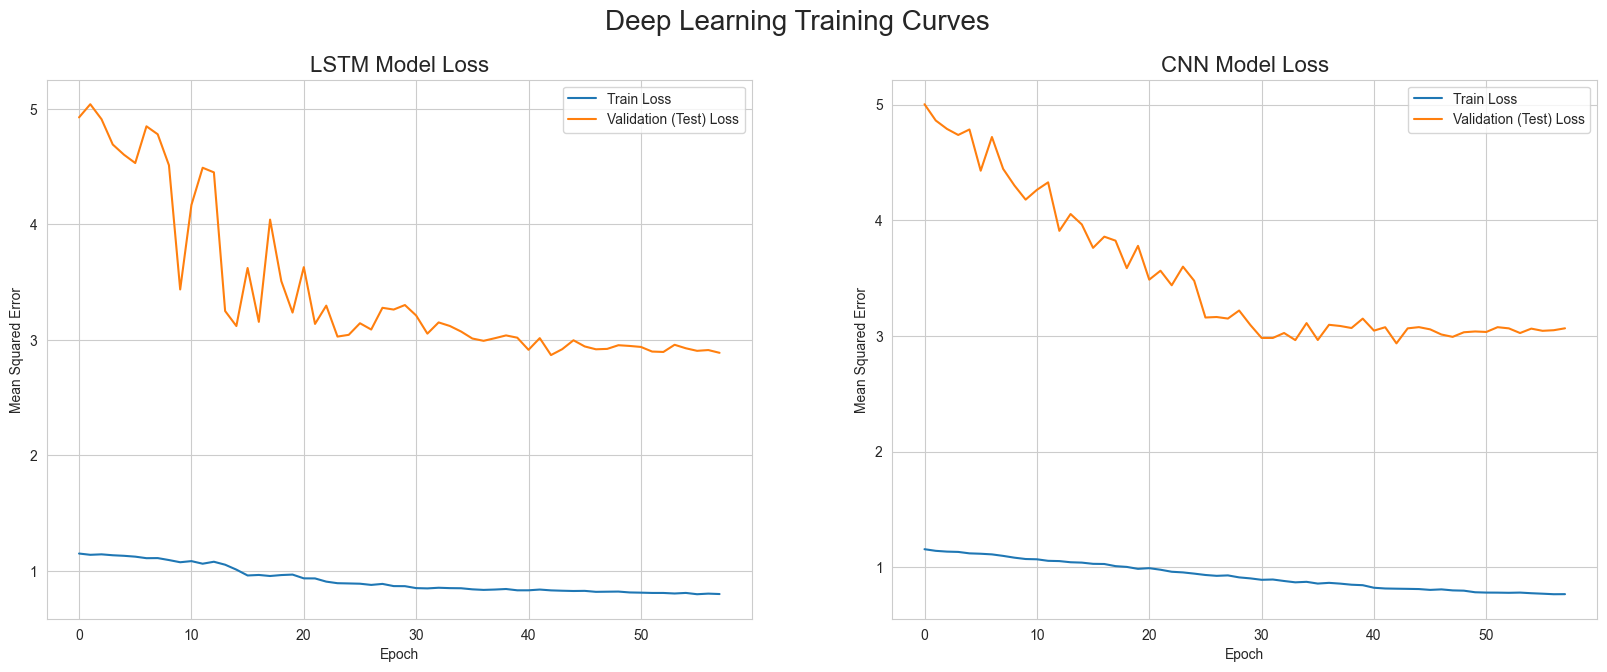

In [ ]:
if RUN_MODELS['LSTM'] and RUN_MODELS['CNN']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    ax1.plot(train_losses_lstm, label='Train Loss')
    ax1.plot(val_losses_lstm, label='Validation (Test) Loss')
    ax1.set_title('LSTM Model Loss', fontsize=16)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Mean Squared Error')
    ax1.legend()
    ax2.plot(train_losses_cnn, label='Train Loss')
    ax2.plot(val_losses_cnn, label='Validation (Test) Loss')
    ax2.set_title('CNN Model Loss', fontsize=16)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Squared Error')
    ax2.legend()
    plt.suptitle('Deep Learning Training Curves', fontsize=20)
    plt.savefig("loss_curves.png")
    plt.show()

## 10. Final Evaluation (Corrected)

In [ ]:
def reconstruct_yield(y_pred_scaled, df_ref, y_scaler_obj):
    """Inverse transforms a prediction to the original yield scale."""
    if y_pred_scaled.ndim == 1:
        y_pred_scaled = y_pred_scaled.reshape(-1, 1)
    
    y_pred_detrended = y_scaler_obj.inverse_transform(y_pred_scaled)
    
    trend = df_ref['yield_trend'].values.reshape(-1, 1)
    y_pred_actual = y_pred_detrended + trend
    
    return y_pred_actual.flatten()

# --- Evaluation ---
results = []
y_preds_original = {}

print("\n--- Final Performance (Test Set) ---")

for name, model in models.items():
    if name in ['LR', 'RF', 'XGB']:
        # Predict on the scaled test set
        preds_scaled = model.predict(X_test_ml)
        # Reconstruct the predictions
        pred_orig = reconstruct_yield(preds_scaled, test_df, y_scaler)
        y_true_orig = test_df[TARGET].values
        # Store for later use
        y_preds_original[name] = pred_orig
        
    elif name in ['LSTM', 'CNN']:
        model.eval()
        with torch.no_grad():
            # Predict on the scaled test set
            preds_scaled_t = model(*[x.to(device) for x in X_test_dl])
            preds_scaled = preds_scaled_t.cpu().numpy()
            # Reconstruct the predictions
            pred_orig = reconstruct_yield(preds_scaled, test_df_dl_seq_ref, y_scaler)
            y_true_orig = test_df_dl_seq_ref[TARGET].values
            # Store for later use
            y_preds_original[name] = pred_orig

    # Calculate metrics
    mae = mean_absolute_error(y_true_orig, pred_orig)
    rmse = np.sqrt(mean_squared_error(y_true_orig, pred_orig))
    map_e = mape(y_true_orig, pred_orig)
    rms_pe = rmspe(y_true_orig, pred_orig)
    r_2 = r2_score(y_true_orig, pred_orig)
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': map_e, 'RMSPE (%)': rms_pe, 'R²': r_2})

results_df = pd.DataFrame(results).set_index('Model').sort_values('RMSE')
print(results_df.round(2))
results_df.to_csv("final_model_performance.csv")


--- Final Performance (Test Set) ---
           MAE      RMSE  MAPE (%)  RMSPE (%)    R²
Model                                              
LR     6320.93  13765.49     10.25      28.87  0.98
RF     6195.43  14693.12     10.24      29.62  0.98
XGB    6487.58  16141.57     10.76      33.48  0.97
LSTM   8925.20  16758.96     12.37      41.56  0.97
CNN    9246.54  17266.94     13.03      44.82  0.97


## 11. Plot Model Performances

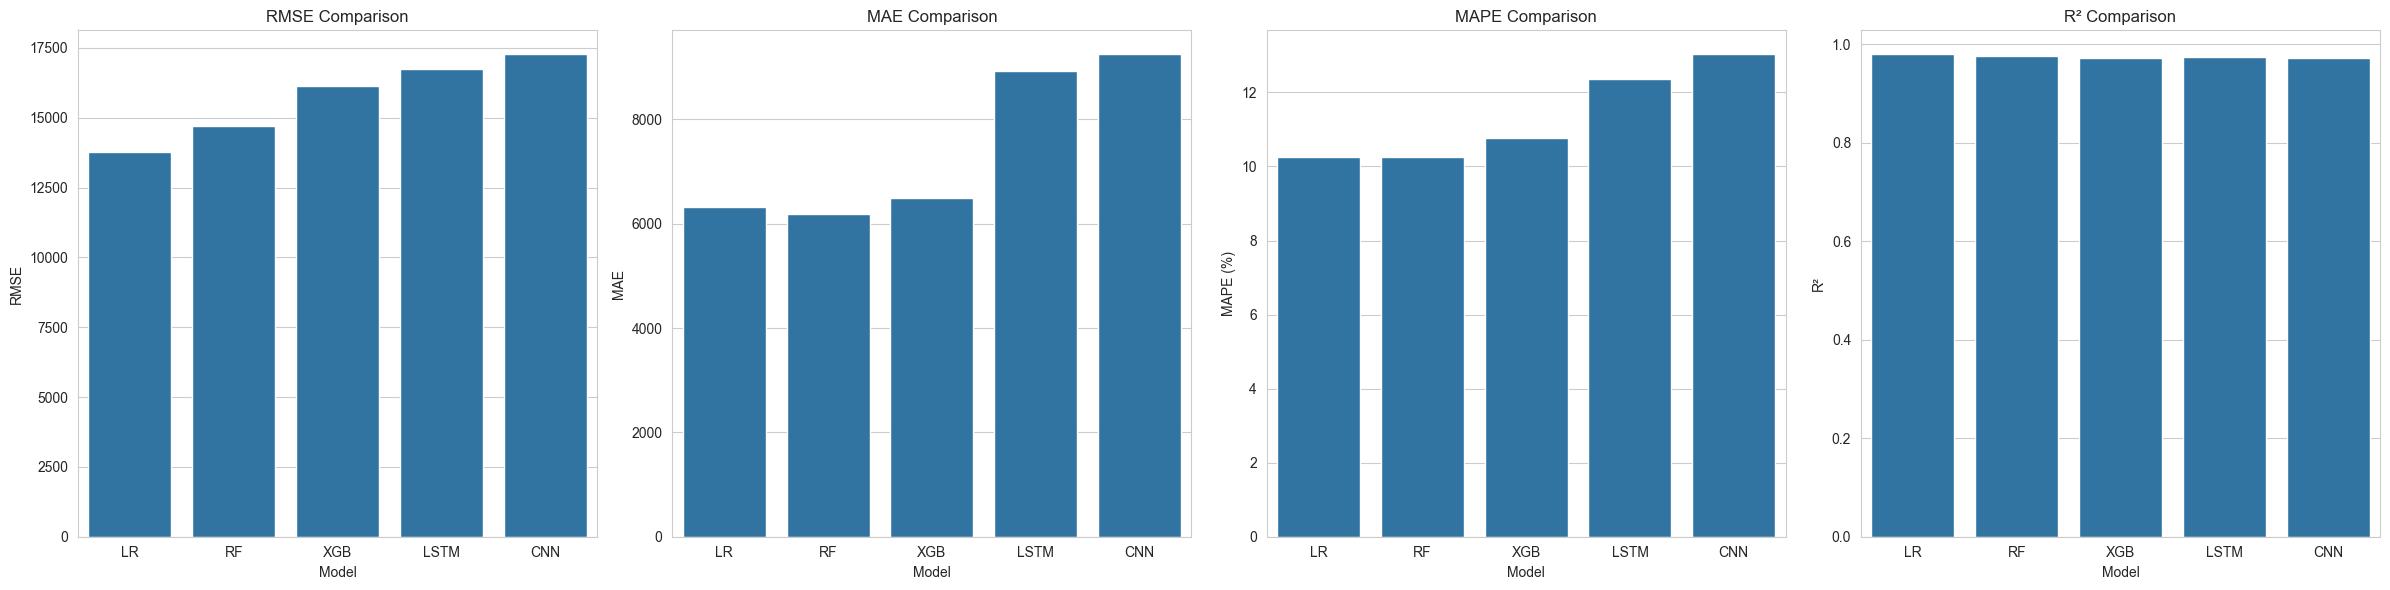

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
sns.barplot(data=results_df.reset_index(), x='Model', y='RMSE', ax=axs[0])
axs[0].set_title('RMSE Comparison')
sns.barplot(x='Model', y='MAE', data=results_df.reset_index(), ax=axs[1])
axs[1].set_title('MAE Comparison')
sns.barplot(x='Model', y='MAPE (%)', data=results_df.reset_index(), ax=axs[2])
axs[2].set_title('MAPE Comparison')
sns.barplot(x='Model', y='R²', data=results_df.reset_index(), ax=axs[3])
axs[3].set_title('R² Comparison')
plt.tight_layout()
plt.savefig("model_performance_comparison.png")
plt.show()

## 12. Per-Crop Reporting (Best Model)

In [ ]:
best_model_name = results_df.index[0]
print(f"Per-crop report for best model: {best_model_name}")
crop_results = []
# Use the correctly aligned test dataframe based on the best model
if best_model_name in ['LR', 'RF', 'XGB']:
    reporting_df = test_df
    y_true_original = reporting_df[TARGET].values
else:
    reporting_df = test_df_dl_seq_ref
    y_true_original = reporting_df[TARGET].values

items = reporting_df['Item'].values

for crop in np.unique(items):
    mask = items == crop
    true = y_true_original[mask]
    pred = y_preds_original[best_model_name][mask]
    if len(true) > 0:
        crop_results.append({
            'Crop': crop,
            'RMSPE (%)': rmspe(true, pred),
            'MAPE (%)': mape(true, pred),
            'RMSE': np.sqrt(mean_squared_error(true, pred)),
            'R²': r2_score(true, pred)
        })
crop_df = pd.DataFrame(crop_results).sort_values('RMSPE (%)')
print(crop_df.round(2))
crop_df.to_csv('per_crop_performance.csv', index=False)

Per-crop report for best model: LR
                   Crop  RMSPE (%)  MAPE (%)      RMSE    R²
7        Sweet potatoes      11.73      7.26  19601.54  0.94
3              Potatoes      12.23      7.10  22178.78  0.95
8                 Wheat      14.91      8.51   4038.31  0.95
1                 Maize      17.43      9.13   7010.21  0.95
4           Rice, paddy      17.84      7.89   5044.25  0.94
9                  Yams      19.97      9.03  15527.71  0.92
0               Cassava      21.30      9.84  19045.36  0.97
6              Soybeans      22.05     10.72   2258.17  0.93
2  Plantains and others      25.55     12.78  29951.18  0.78
5               Sorghum      72.24     23.27   9877.67  0.75


## 13. SHAP Analysis (If Tree Model)

In [ ]:
best_model_name = results_df.index[0]
if best_model_name in models and best_model_name in ['RF', 'XGB']:
    best_model = models[best_model_name]
    print(f"Running SHAP on {best_model_name}")
    # For SHAP, we need to use the correctly aligned test features
    X_test_shap = X_test_ml
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_shap)
    shap.summary_plot(shap_values, X_test_shap, plot_type="beeswarm", show=False)
    plt.title(f"SHAP Beeswarm ({best_model_name})", fontsize=16)
    plt.savefig("shap_beeswarm.png", bbox_inches='tight')
    plt.show()
    shap.summary_plot(shap_values, X_test_shap, plot_type="bar", show=False)
    plt.title(f"Feature Importance ({best_model_name})", fontsize=16)
    plt.savefig("shap_importance.png", bbox_inches='tight')
    plt.show()
else:
    print("SHAP skipped for non-tree model.")

SHAP skipped for non-tree model.


## 14. Export Predictions

In [ ]:
# Create a base dataframe for predictions. ML models have more test samples than DL models.
final_predictions_df = test_df.copy()
final_predictions_df['true_yield_original'] = final_predictions_df[TARGET]

# Add predictions. Note that DL predictions will have NaNs for non-sequenced rows.
for name, preds in y_preds_original.items():
    if name in ['LR', 'RF', 'XGB']:
        final_predictions_df[f'predicted_{name}'] = preds
    else:
        # Align DL predictions with the main test dataframe
        dl_preds_series = pd.Series(preds, index=test_df_dl_seq_ref.index, name=f'predicted_{name}')
        final_predictions_df = final_predictions_df.join(dl_preds_series)

export_cols = ['Year', 'Area', 'Item', 'true_yield_original'] + [f'predicted_{name}' for name in models.keys()]
final_predictions_df[export_cols].to_csv("final_test_predictions.csv", index=False)
print("Exported predictions.")
print("\n--- Complete ---")

Exported predictions.

--- Complete ---
